In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import matplotlib.pylab as plt
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from learning2learn.wrangle import synthesize_data
from learning2learn.wrangle import get_train_test_parameters 
from learning2learn.wrangle import build_train_set
from learning2learn.wrangle import build_test_trials_order1
from learning2learn.wrangle import build_test_trials_order2
from learning2learn.util import get_hidden_representations
from learning2learn.util import train_test_split
#from learning2learn.util import train_model
from learning2learn.util import similarity
#from learning2learn.images import generate_image
#from learning2learn.images import shift_image
#from learning2learn.images import generate_random_shape
#from learning2learn.models import simple_cnn

/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='1')
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

In [2]:
def synthesize_data_multi(nb_shapes, nb_colors, nb_textures, nb_exemplars):
    shapes = []
    for i in range(nb_shapes):
        shapes.extend([i for _ in range(nb_exemplars)])
    colors = np.random.choice(range(nb_colors), size=nb_shapes*nb_exemplars)
    textures = np.random.choice(range(nb_textures), size=nb_shapes*nb_exemplars)
    df = pd.DataFrame(columns=['shape', 'color', 'texture'])
    df['shape'] = shapes
    df['color'] = colors
    df['texture'] = textures

    return df

In [3]:
def get_train_data(nb_shapes, nb_colors, nb_textures, nb_exemplars, 
                   shift_scale=20, target_size=(200,200)):
    assert nb_shapes <= 50 and nb_colors <=50 and nb_textures <= 50
    np.random.seed(0)
    (shape_set_train, shape_set_test), \
    (color_set_train, color_set_test), \
    (texture_set_train, texture_set_test) = \
        get_train_test_parameters(images=True, img_size=target_size[0])
    if nb_shapes < 50:
        shape_set_train, _ = train_test_split(shape_set_train, 50-nb_shapes)
    if nb_colors < 50:
        color_set_train, _ = train_test_split(color_set_train, 50-nb_colors)
    if nb_textures < 50:
        texture_set_train, _ = train_test_split(texture_set_train, 50-nb_textures)
    df_train = synthesize_data_multi(nb_shapes, nb_colors, nb_textures, nb_exemplars)
    X_train = build_train_set(
        df_train, shape_set_train, color_set_train,
        texture_set_train,
        target_size=target_size,
        shift_scale=shift_scale
    )
    shapes = df_train['shape'].values
    colors = df_train['color'].values
    textures = df_train['texture'].values
    ohe = OneHotEncoder(sparse=False)
    Y_shape = ohe.fit_transform(shapes.reshape(-1, 1))
    Y_color = ohe.fit_transform(colors.reshape(-1, 1))
    Y_texture = ohe.fit_transform(textures.reshape(-1, 1))
    
    return X_train, Y_shape, Y_color, Y_texture

def get_test_data(nb_trials=1000, shift_scale=20, target_size=(200, 200)):
    np.random.seed(0)
    (shape_set_train, shape_set_test), \
    (color_set_train, color_set_test), \
    (texture_set_train, texture_set_test) = \
        get_train_test_parameters(images=True, img_size=target_size[0])
    X_test = build_test_trials_order2(
        shape_set_test, color_set_test, texture_set_test,
        nb_trials=nb_trials, shift_scale=shift_scale
    )
    
    return X_test

In [4]:
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                          Activation, Dropout, Dense)
from keras.regularizers import l2
from keras.models import Model

def simple_cnn_multiout(input_shape, nb_shapes, nb_colors, nb_textures, loss_weights=None):
    layers = [
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Conv, Pool
        Conv2D(5, (5, 5), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(5, 5)),
        # Flatten
        Flatten(),
        # Hidden layer
        Dropout(0.2),
        Dense(25, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        # Output layer
        Dropout(0.5),
    ]
    image_in = Input(shape=input_shape, dtype='float32', name='image_in')
    x = layers[0](image_in)
    for layer in layers[1:]:
        x = layer(x)
    shape_out = Dense(nb_shapes, activation='softmax', name='shape_out')(x)
    color_out = Dense(nb_colors, activation='softmax', name='color_out')(x)
    texture_out = Dense(nb_textures, activation='softmax', name='texture_out')(x)

    model = Model(
        inputs=[image_in], 
        outputs=[shape_out, color_out, texture_out]
    )
    if loss_weights is None:
        model.compile(
            optimizer='rmsprop', 
            loss='categorical_crossentropy', 
        )
    else:
        model.compile(
        optimizer='rmsprop', 
        loss='categorical_crossentropy',
        loss_weights=loss_weights
    )
    
    return model

In [160]:
def evaluate_generalization(model, X, layer_num, metric='cosine'):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X) % 4 == 0
    X_p = get_hidden_representations(model, X, layer_num=layer_num, batch_size=128)
    nb_trials = len(X_p)/4.
    counts = {0:0, 1:0, 2:0}
    for i in range(int(nb_trials)):
        scores = np.zeros(3)
        scores[0] = similarity(X_p[4*i], X_p[4*i+1], metric) # shape match score
        scores[1] = similarity(X_p[4*i], X_p[4*i+2], metric) # color match score
        scores[2] = similarity(X_p[4*i], X_p[4*i+3], metric) # texture match score
        match = np.argmax(scores)
        others = list(range(3))
        others.remove(match)
        # sanity check here because argmax takes first option by default
        if (scores[match] == scores[others[0]] or scores[match] == scores[others[1]]):
            match = np.random.choice(range(3), 1)[0]
        counts[match] += 1

    # Return the percentage of times we were correct
    return counts[0]/nb_trials, counts[1]/nb_trials, counts[2]/nb_trials

In [14]:
nb_shapes = 30
nb_colors = 20
nb_textures = 20
nb_exemplars = 10
batch_size = min(32, int(np.floor(nb_shapes*nb_exemplars/5)))

In [15]:
X_train, Y_shape, Y_color, Y_texture = get_train_data(
    nb_shapes, nb_colors, nb_textures, nb_exemplars, shift_scale=20
)

In [87]:
X_test = get_test_data(nb_trials=500, shift_scale=20)

In [16]:
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
)

In [17]:
Y_pred_s = get_hidden_representations(model, X_train[:20], layer_num=-3, batch_size=128)
Y_pred_c = get_hidden_representations(model, X_train[:20], layer_num=-2, batch_size=128)
Y_pred_t = get_hidden_representations(model, X_train[:20], layer_num=-1, batch_size=128)

In [18]:
print(Y_pred_s.shape)
print(Y_pred_c.shape)
print(Y_pred_t.shape)

(20, 30)
(20, 20)
(20, 20)


In [115]:
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
)
score_s, score_c, score_t = evaluate_generalization(model, X_test, layer_num=-5)
print('shape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
      (score_s, score_c, score_t))

			shape bias: 0.3240	 - color bias: 0.4560	 - texture bias: 0.2200



In [63]:
list(enumerate(model.layers))

[(0, <keras.engine.topology.InputLayer at 0x7ff481b2f4e0>),
 (1, <keras.layers.convolutional.Conv2D at 0x7ff481b17c50>),
 (2, <keras.layers.core.Activation at 0x7ff481b17da0>),
 (3, <keras.layers.pooling.MaxPooling2D at 0x7ff481b17e48>),
 (4, <keras.layers.convolutional.Conv2D at 0x7ff481b17f28>),
 (5, <keras.layers.core.Activation at 0x7ff481b17f60>),
 (6, <keras.layers.pooling.MaxPooling2D at 0x7ff481b2f128>),
 (7, <keras.layers.core.Flatten at 0x7ff481b2f1d0>),
 (8, <keras.layers.core.Dropout at 0x7ff481b2f240>),
 (9, <keras.layers.core.Dense at 0x7ff481b2f2b0>),
 (10, <keras.layers.core.Activation at 0x7ff481b2f470>),
 (11, <keras.layers.core.Dropout at 0x7ff481b2f4a8>),
 (12, <keras.layers.core.Dense at 0x7ff481b3fc18>),
 (13, <keras.layers.core.Dense at 0x7ff481a89940>),
 (14, <keras.layers.core.Dense at 0x7ff481a288d0>)]

In [116]:
nb_epoch = 50
scores_s = np.zeros(nb_epoch+1)
scores_c = np.zeros(nb_epoch+1)
scores_t = np.zeros(nb_epoch+1)
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
)
scores_s[0], scores_c[0], scores_t[0] = evaluate_generalization(model, X_test, layer_num=-5)
print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
      (scores_s[0], scores_c[0], scores_t[0]))
for i in range(1, nb_epoch+1):
    print('Epoch %i of %i' % (i, nb_epoch))
    model.fit(
        [X_train],
        [Y_shape, Y_color, Y_texture],
        epochs=1,
        batch_size=batch_size,
        verbose=2
    )
    scores_s[i], scores_c[i], scores_t[i] = evaluate_generalization(model, X_test, layer_num=-5)
    print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
          (scores_s[i], scores_c[i], scores_t[i]))

			shape bias: 0.2560	 - color bias: 0.4600	 - texture bias: 0.2840

Epoch 1 of 50
Epoch 1/1
 - 2s - loss: 10.7608 - shape_out_loss: 3.4318 - color_out_loss: 3.4181 - texture_out_loss: 3.4007
			shape bias: 0.2380	 - color bias: 0.5160	 - texture bias: 0.2460

Epoch 2 of 50
Epoch 1/1
 - 0s - loss: 10.6545 - shape_out_loss: 3.4113 - color_out_loss: 3.3975 - texture_out_loss: 3.3899
			shape bias: 0.3120	 - color bias: 0.3560	 - texture bias: 0.3320

Epoch 3 of 50
Epoch 1/1
 - 0s - loss: 10.5828 - shape_out_loss: 3.4034 - color_out_loss: 3.3958 - texture_out_loss: 3.3641
			shape bias: 0.3020	 - color bias: 0.3320	 - texture bias: 0.3660

Epoch 4 of 50
Epoch 1/1
 - 0s - loss: 10.5477 - shape_out_loss: 3.4020 - color_out_loss: 3.3903 - texture_out_loss: 3.3672
			shape bias: 0.1500	 - color bias: 0.6400	 - texture bias: 0.2100

Epoch 5 of 50
Epoch 1/1
 - 0s - loss: 10.4659 - shape_out_loss: 3.3914 - color_out_loss: 3.3778 - texture_out_loss: 3.3343
			shape bias: 0.2560	 - color bias: 0.3

			shape bias: 0.1520	 - color bias: 0.7300	 - texture bias: 0.1180

Epoch 44 of 50
Epoch 1/1
 - 0s - loss: 8.6600 - shape_out_loss: 2.7940 - color_out_loss: 2.7139 - texture_out_loss: 2.8797
			shape bias: 0.1600	 - color bias: 0.6880	 - texture bias: 0.1520

Epoch 45 of 50
Epoch 1/1
 - 0s - loss: 8.7766 - shape_out_loss: 2.7593 - color_out_loss: 2.7525 - texture_out_loss: 2.9920
			shape bias: 0.1440	 - color bias: 0.7420	 - texture bias: 0.1140

Epoch 46 of 50
Epoch 1/1
 - 0s - loss: 8.7625 - shape_out_loss: 2.9342 - color_out_loss: 2.6479 - texture_out_loss: 2.9072
			shape bias: 0.1640	 - color bias: 0.7240	 - texture bias: 0.1120

Epoch 47 of 50
Epoch 1/1
 - 0s - loss: 8.5616 - shape_out_loss: 2.7829 - color_out_loss: 2.6207 - texture_out_loss: 2.8840
			shape bias: 0.1480	 - color bias: 0.7280	 - texture bias: 0.1240

Epoch 48 of 50
Epoch 1/1
 - 0s - loss: 8.5627 - shape_out_loss: 2.7628 - color_out_loss: 2.6240 - texture_out_loss: 2.9014
			shape bias: 0.1420	 - color bias: 0.7

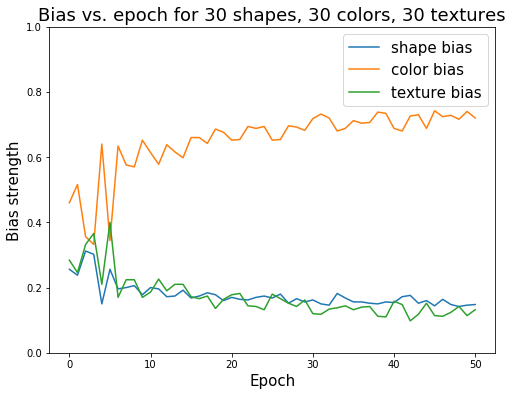

In [119]:
x = range(nb_epoch+1)
plt.figure(figsize=(8,6))
plt.plot(x, scores_s, label='shape bias')
plt.plot(x, scores_c, label='color bias')
plt.plot(x, scores_t, label='texture bias')
plt.ylim(0,1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Bias strength', fontsize=15)
plt.title('Bias vs. epoch for 30 shapes, 30 colors, 30 textures', fontsize=18)
plt.legend(fontsize=15)
plt.show()

In [120]:
# Now try with more shape categories than color or texture

In [121]:
nb_shapes = 30
nb_colors = 2
nb_textures = 2
nb_exemplars = 10
batch_size = min(32, int(np.floor(nb_shapes*nb_exemplars/5)))

In [122]:
X_train, Y_shape, Y_color, Y_texture = get_train_data(
    nb_shapes, nb_colors, nb_textures, nb_exemplars, shift_scale=20
)

In [123]:
nb_epoch = 50
scores_s = np.zeros(nb_epoch+1)
scores_c = np.zeros(nb_epoch+1)
scores_t = np.zeros(nb_epoch+1)
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
)
scores_s[0], scores_c[0], scores_t[0] = evaluate_generalization(model, X_test, layer_num=-5)
print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
      (scores_s[0], scores_c[0], scores_t[0]))
for i in range(1, nb_epoch+1):
    print('Epoch %i of %i' % (i, nb_epoch))
    model.fit(
        [X_train],
        [Y_shape, Y_color, Y_texture],
        epochs=1,
        batch_size=batch_size,
        verbose=2
    )
    scores_s[i], scores_c[i], scores_t[i] = evaluate_generalization(model, X_test, layer_num=-5)
    print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
          (scores_s[i], scores_c[i], scores_t[i]))

			shape bias: 0.4880	 - color bias: 0.3220	 - texture bias: 0.1900

Epoch 1 of 50
Epoch 1/1
 - 2s - loss: 5.6063 - shape_out_loss: 3.5631 - color_out_loss: 0.7302 - texture_out_loss: 0.7806
			shape bias: 0.4420	 - color bias: 0.3180	 - texture bias: 0.2400

Epoch 2 of 50
Epoch 1/1
 - 0s - loss: 5.2269 - shape_out_loss: 3.4174 - color_out_loss: 0.6548 - texture_out_loss: 0.6548
			shape bias: 0.4140	 - color bias: 0.3460	 - texture bias: 0.2400

Epoch 3 of 50
Epoch 1/1
 - 0s - loss: 5.1192 - shape_out_loss: 3.4295 - color_out_loss: 0.5715 - texture_out_loss: 0.6428
			shape bias: 0.2620	 - color bias: 0.5560	 - texture bias: 0.1820

Epoch 4 of 50
Epoch 1/1
 - 0s - loss: 5.0554 - shape_out_loss: 3.4422 - color_out_loss: 0.5041 - texture_out_loss: 0.6549
			shape bias: 0.2440	 - color bias: 0.5300	 - texture bias: 0.2260

Epoch 5 of 50
Epoch 1/1
 - 0s - loss: 4.9222 - shape_out_loss: 3.4324 - color_out_loss: 0.4104 - texture_out_loss: 0.6449
			shape bias: 0.2180	 - color bias: 0.5500	 

			shape bias: 0.1600	 - color bias: 0.4980	 - texture bias: 0.3420

Epoch 44 of 50
Epoch 1/1
 - 0s - loss: 3.5124 - shape_out_loss: 3.1262 - color_out_loss: 0.0766 - texture_out_loss: 0.0994
			shape bias: 0.1440	 - color bias: 0.5040	 - texture bias: 0.3520

Epoch 45 of 50
Epoch 1/1
 - 0s - loss: 3.5357 - shape_out_loss: 3.0895 - color_out_loss: 0.1042 - texture_out_loss: 0.1326
			shape bias: 0.1560	 - color bias: 0.4460	 - texture bias: 0.3980

Epoch 46 of 50
Epoch 1/1
 - 0s - loss: 3.4789 - shape_out_loss: 3.0951 - color_out_loss: 0.0816 - texture_out_loss: 0.0934
			shape bias: 0.1480	 - color bias: 0.6100	 - texture bias: 0.2420

Epoch 47 of 50
Epoch 1/1
 - 0s - loss: 3.5049 - shape_out_loss: 3.1129 - color_out_loss: 0.0692 - texture_out_loss: 0.1150
			shape bias: 0.1520	 - color bias: 0.5040	 - texture bias: 0.3440

Epoch 48 of 50
Epoch 1/1
 - 0s - loss: 3.4753 - shape_out_loss: 3.0658 - color_out_loss: 0.0751 - texture_out_loss: 0.1275
			shape bias: 0.1600	 - color bias: 0.4

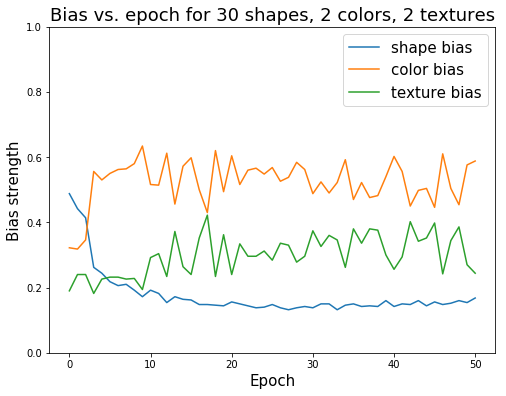

In [124]:
x = range(nb_epoch+1)
plt.figure(figsize=(8,6))
plt.plot(x, scores_s, label='shape bias')
plt.plot(x, scores_c, label='color bias')
plt.plot(x, scores_t, label='texture bias')
plt.ylim(0,1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Bias strength', fontsize=15)
plt.title('Bias vs. epoch for 30 shapes, 2 colors, 2 textures', fontsize=18)
plt.legend(fontsize=15)
plt.show()

In [ ]:
# Now try weighting each of the 3 predictors differently, proportional to their category proportions

In [133]:
# nb_shapes = 50
# nb_colors = 5
# nb_textures = 5
# nb_exemplars = 10
# w_s = nb_shapes /(nb_shapes+nb_colors+nb_textures)
# w_c = nb_colors /(nb_shapes+nb_colors+nb_textures)
# w_t = nb_textures /(nb_shapes+nb_colors+nb_textures)

In [161]:
total = 60
w_s = 0.8
w_c = 0.1
w_t = 0.1
nb_shapes = int(np.round(w_s*total))
nb_colors = int(np.round(w_c*total))
nb_textures = total - nb_shapes - nb_colors
print('nb_shapes: %i' % nb_shapes)
print('nb_colors: %i' % nb_colors)
print('nb_textures: %i' % nb_textures)

nb_shapes: 48
nb_colors: 6
nb_textures: 6


In [162]:
X_train, Y_shape, Y_color, Y_texture = get_train_data(
    nb_shapes, nb_colors, nb_textures, nb_exemplars, shift_scale=20
)

In [163]:
nb_epoch = 50
scores_s = np.zeros(nb_epoch+1)
scores_c = np.zeros(nb_epoch+1)
scores_t = np.zeros(nb_epoch+1)
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
    loss_weights=[w_s, w_c, w_t]
)
scores_s[0], scores_c[0], scores_t[0] = evaluate_generalization(model, X_test, layer_num=-5)
print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
      (scores_s[0], scores_c[0], scores_t[0]))
for i in range(1, nb_epoch+1):
    print('Epoch %i of %i' % (i, nb_epoch))
    model.fit(
        [X_train],
        [Y_shape, Y_color, Y_texture],
        epochs=1,
        batch_size=1,
        verbose=2
    )
    scores_s[i], scores_c[i], scores_t[i] = evaluate_generalization(model, X_test, layer_num=-5)
    print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
          (scores_s[i], scores_c[i], scores_t[i]))
    if np.abs((scores_s[i] + scores_c[i] + scores_t[i]) - 1.) > 1e-3:
        break

			shape bias: 0.4060	 - color bias: 0.3640	 - texture bias: 0.2300

Epoch 1 of 50
Epoch 1/1
 - 7s - loss: 3.5816 - shape_out_loss: 3.8904 - color_out_loss: 1.8036 - texture_out_loss: 1.8044
			shape bias: 0.2120	 - color bias: 0.3300	 - texture bias: 0.4580

Epoch 2 of 50
Epoch 1/1
 - 5s - loss: 3.4638 - shape_out_loss: 3.8812 - color_out_loss: 1.7921 - texture_out_loss: 1.7903


/home/feinman/.local/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 3 of 50
Epoch 1/1
 - 5s - loss: 3.4629 - shape_out_loss: 3.8811 - color_out_loss: 1.7917 - texture_out_loss: 1.7886
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 4 of 50
Epoch 1/1
 - 5s - loss: 3.4621 - shape_out_loss: 3.8801 - color_out_loss: 1.7917 - texture_out_loss: 1.7879
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 5 of 50
Epoch 1/1
 - 5s - loss: 3.4628 - shape_out_loss: 3.8811 - color_out_loss: 1.7915 - texture_out_loss: 1.7875
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 6 of 50
Epoch 1/1
 - 5s - loss: 3.4629 - shape_out_loss: 3.8813 - color_out_loss: 1.7915 - texture_out_loss: 1.7870
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 7 of 50
Epoch 1/1
 - 5s - loss: 3.4628 - shape_out_loss: 3.8812 - color_out_loss: 1.7916 - texture_out_loss: 1.7869
			shape bias: 1.0000	 - color bias: 0.0000	 

			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 46 of 50
Epoch 1/1
 - 5s - loss: 3.4637 - shape_out_loss: 3.8822 - color_out_loss: 1.7915 - texture_out_loss: 1.7872
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 47 of 50
Epoch 1/1
 - 5s - loss: 3.4632 - shape_out_loss: 3.8817 - color_out_loss: 1.7916 - texture_out_loss: 1.7869
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 48 of 50
Epoch 1/1
 - 5s - loss: 3.4631 - shape_out_loss: 3.8814 - color_out_loss: 1.7917 - texture_out_loss: 1.7873
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 49 of 50
Epoch 1/1
 - 5s - loss: 3.4630 - shape_out_loss: 3.8814 - color_out_loss: 1.7916 - texture_out_loss: 1.7871
			shape bias: 1.0000	 - color bias: 0.0000	 - texture bias: 0.0000

Epoch 50 of 50
Epoch 1/1
 - 5s - loss: 3.4626 - shape_out_loss: 3.8809 - color_out_loss: 1.7916 - texture_out_loss: 1.7869
			shape bias: 1.0000	 - color bias: 0.0

In [168]:
# def compute_similarities(model, X, layer_num, metric='cosine'):
#     # Since we have groupings of 4 samples, X should have a length that is a
#     # multiple of 4.
#     assert len(X) % 4 == 0
#     X_p = get_hidden_representations(model, X, layer_num=layer_num, batch_size=128)
#     nb_trials = int(len(X_p)/4.)
#     similarities = np.zeros((nb_trials, 3))
#     for i in range(nb_trials):
#         similarities[i,0] = similarity(X_p[4*i], X_p[4*i+1], metric)
#         similarities[i,1] = similarity(X_p[4*i], X_p[4*i+2], metric)
#         similarities[i,2] = similarity(X_p[4*i], X_p[4*i+3], metric)
        
#     return similarities

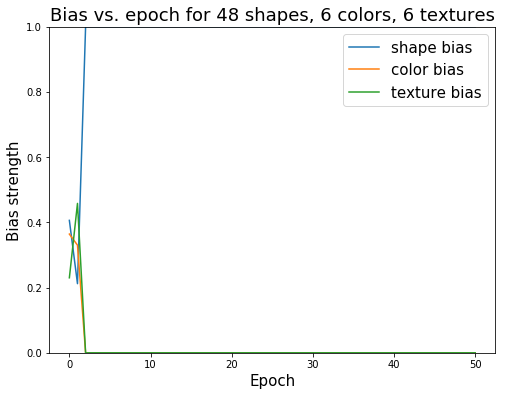

In [165]:
x = range(nb_epoch+1)
plt.figure(figsize=(8,6))
plt.plot(x, scores_s, label='shape bias')
plt.plot(x, scores_c, label='color bias')
plt.plot(x, scores_t, label='texture bias')
plt.ylim(0,1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Bias strength', fontsize=15)
plt.title('Bias vs. epoch for %i shapes, %i colors, %i textures' % 
          (nb_shapes, nb_colors, nb_textures), fontsize=18)
plt.legend(fontsize=15)
plt.show()

In [166]:
total = 60
w_s = 0.6
w_c = 0.2
w_t = 0.2
nb_shapes = int(np.round(w_s*total))
nb_colors = int(np.round(w_c*total))
nb_textures = total - nb_shapes - nb_colors
print('nb_shapes: %i' % nb_shapes)
print('nb_colors: %i' % nb_colors)
print('nb_textures: %i' % nb_textures)

X_train, Y_shape, Y_color, Y_texture = get_train_data(
    nb_shapes, nb_colors, nb_textures, nb_exemplars, shift_scale=20
)

nb_epoch = 50
scores_s = np.zeros(nb_epoch+1)
scores_c = np.zeros(nb_epoch+1)
scores_t = np.zeros(nb_epoch+1)
model = simple_cnn_multiout(
    input_shape=X_train.shape[1:], 
    nb_shapes=Y_shape.shape[-1],
    nb_colors=Y_color.shape[-1],
    nb_textures=Y_texture.shape[-1],
    loss_weights=[w_s, w_c, w_t]
)
scores_s[0], scores_c[0], scores_t[0] = evaluate_generalization(model, X_test, layer_num=-5)
print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
      (scores_s[0], scores_c[0], scores_t[0]))
for i in range(1, nb_epoch+1):
    print('Epoch %i of %i' % (i, nb_epoch))
    model.fit(
        [X_train],
        [Y_shape, Y_color, Y_texture],
        epochs=1,
        batch_size=1,
        verbose=2
    )
    scores_s[i], scores_c[i], scores_t[i] = evaluate_generalization(model, X_test, layer_num=-5)
    print('\t\t\tshape bias: %0.4f\t - color bias: %0.4f\t - texture bias: %0.4f\n' % 
          (scores_s[i], scores_c[i], scores_t[i]))

nb_shapes: 36
nb_colors: 12
nb_textures: 12
			shape bias: 0.4100	 - color bias: 0.4060	 - texture bias: 0.1840

Epoch 1 of 50
Epoch 1/1
 - 6s - loss: 3.3698 - shape_out_loss: 3.6302 - color_out_loss: 2.4831 - texture_out_loss: 2.5025
			shape bias: 0.2280	 - color bias: 0.5000	 - texture bias: 0.2720

Epoch 2 of 50
Epoch 1/1
 - 4s - loss: 3.1655 - shape_out_loss: 3.5932 - color_out_loss: 2.4257 - texture_out_loss: 2.5026
			shape bias: 0.2720	 - color bias: 0.4320	 - texture bias: 0.2960

Epoch 3 of 50
Epoch 1/1
 - 4s - loss: 3.1410 - shape_out_loss: 3.5964 - color_out_loss: 2.3746 - texture_out_loss: 2.4774
			shape bias: 0.2360	 - color bias: 0.5380	 - texture bias: 0.2260

Epoch 4 of 50
Epoch 1/1
 - 4s - loss: 3.1267 - shape_out_loss: 3.5868 - color_out_loss: 2.3260 - texture_out_loss: 2.4997
			shape bias: 0.1560	 - color bias: 0.5360	 - texture bias: 0.3080

Epoch 5 of 50
Epoch 1/1
 - 4s - loss: 3.1253 - shape_out_loss: 3.5974 - color_out_loss: 2.3016 - texture_out_loss: 2.4952
	

 - 4s - loss: 3.0344 - shape_out_loss: 3.5527 - color_out_loss: 2.0231 - texture_out_loss: 2.4701
			shape bias: 0.2720	 - color bias: 0.4920	 - texture bias: 0.2360

Epoch 44 of 50
Epoch 1/1
 - 4s - loss: 3.0307 - shape_out_loss: 3.5423 - color_out_loss: 2.0243 - texture_out_loss: 2.4812
			shape bias: 0.2600	 - color bias: 0.4740	 - texture bias: 0.2660

Epoch 45 of 50
Epoch 1/1
 - 4s - loss: 3.0450 - shape_out_loss: 3.5451 - color_out_loss: 2.0721 - texture_out_loss: 2.4965
			shape bias: 0.2680	 - color bias: 0.4420	 - texture bias: 0.2900

Epoch 46 of 50
Epoch 1/1
 - 4s - loss: 3.0315 - shape_out_loss: 3.5354 - color_out_loss: 2.0482 - texture_out_loss: 2.4816
			shape bias: 0.2300	 - color bias: 0.5140	 - texture bias: 0.2560

Epoch 47 of 50
Epoch 1/1
 - 4s - loss: 3.0309 - shape_out_loss: 3.5275 - color_out_loss: 2.0689 - texture_out_loss: 2.4821
			shape bias: 0.2120	 - color bias: 0.5660	 - texture bias: 0.2220

Epoch 48 of 50
Epoch 1/1
 - 4s - loss: 3.0222 - shape_out_loss: 3

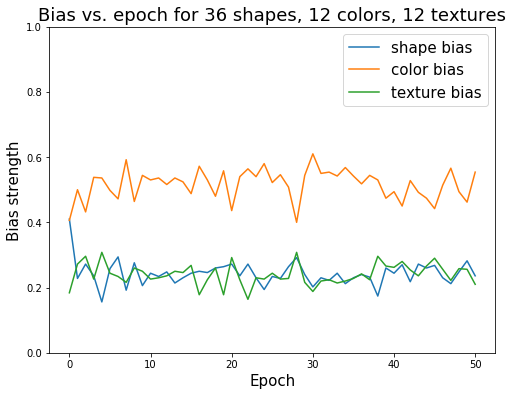

In [167]:
x = range(nb_epoch+1)
plt.figure(figsize=(8,6))
plt.plot(x, scores_s, label='shape bias')
plt.plot(x, scores_c, label='color bias')
plt.plot(x, scores_t, label='texture bias')
plt.ylim(0,1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Bias strength', fontsize=15)
plt.title('Bias vs. epoch for %i shapes, %i colors, %i textures' % 
          (nb_shapes, nb_colors, nb_textures), fontsize=18)
plt.legend(fontsize=15)
plt.show()